# PCA in Spark ML

Let's try our hands at dimensionality reduction in Spark MLLib.  We are going to look at the Walmart Dataset. Remember how many dimensions we had in that one? (70, to be exact). Perhaps we can get a lower-dimensional representation of that.


In [10]:
%matplotlib inline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA

import numpy as np
import matplotlib
import matplotlib.pyplot as plt



In [11]:
dataset = spark.read.csv("/data/walmart-triptype/train-transformed.csv.gz", header=True, inferSchema=True)


In [12]:
dataset.show()

+-----------+--------+-------+--------+------+----------+-----------+----------+------+---------------+------+-------+-------------------+---------+----------------+--------------------+-----------------------+-----------+----------+--------------+-------------+-----+-----------+-----------+------------------+------------------+------------+---------+--------------------------+-----------------+--------+----------------------+----------+---------------+-----------------------+------------------------+---------------------+-------------------+--------------+---------------------------+----------------------+------------+----------+---------------------+---------------+----------------+---------------------+----------------+--------+---------------+----------------+----------------+-----------------+---------------------+-------------+-----------------+------------+-----------+-----------------------+------------------+---------------+-------+-------+--------+------------+-------------+-

## Step 1: Creating Vectors

Let's load the data and create vectors out of it.

In [13]:
columns = dataset.columns
columns.remove('VisitNumber') #We don't care about visit number as a feature.
columns.remove('TripType') #Triptype is what we're predicting!

print(columns)

['Weekday', 'NumItems', 'Return', '1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY', 'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES', 'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14', 'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR', 'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS', 'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS', 'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR', 'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR', 'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES', 'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE', 'PETS AND SUPPLIE

In [14]:
# Build the vector.
assembler = VectorAssembler(inputCols=columns, outputCol="features")
featureVector = assembler.transform(dataset)


In [15]:
# Print some sample rows.
for row in featureVector.select('features').take(10):
    print("Vector: %s\n" % (str(row)))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: -1.0, 2: 1.0, 23: -1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 2.0, 52: 1.0, 64: 1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 28.0, 2: 1.0, 19: 2.0, 20: 1.0, 33: 1.0, 44: 1.0, 51: 18.0, 53: 4.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 3.0, 35: 1.0, 59: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 3.0, 14: 1.0, 20: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 4.0, 20: 1.0, 27: 1.0, 35: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 7.0, 11: 2.0, 33: 2.0, 52: 2.0, 64: 1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 9.0, 22: 9.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 4.0, 14: 2.0, 20: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 9.0, 4: 1.0, 22: 1.0, 31: 1.0, 35: 2.0, 38: 1.0, 46: 3.0}))



Note the output. These are Sparse (not dense) Vectors.  That's because we our data IS sparse, we have relatively few of the variables at any given time.

## Step 2: Build a Correlation Matrix

We're going to build a correlation matrix.  This will have all features as rows and columns, showing what is the correlation between variables.  Naturally, every feature will be perfectly correlated to itself, so we expect to see a diagonal of 1's.  Correlations in the upper right and lower left should also be mirror images of each other.

Perfectly uncorrelated features (orthogonal) would have the identity matrix as its correlation matrix.  Part of our goal in PCA is to create orthogonal features.

In [16]:
## Checking the correlation matrix of the data.

r1 = Correlation.corr(featureVector, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))


Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.04112535,  0.00239757, ...,  0.00603346,
               0.02650173,  0.00378734],
             [ 0.04112535,  1.        , -0.04703964, ...,  0.03728566,
               0.10396361, -0.0131882 ],
             [ 0.00239757, -0.04703964,  1.        , ..., -0.02663534,
              -0.02400574, -0.03420455],
             ..., 
             [ 0.00603346,  0.03728566, -0.02663534, ...,  1.        ,
               0.01531549, -0.00357236],
             [ 0.02650173,  0.10396361, -0.02400574, ...,  0.01531549,
               1.        ,  0.00143963],
             [ 0.00378734, -0.0131882 , -0.03420455, ..., -0.00357236,
               0.00143963,  1.        ]])


Note that there are some correlated dimensions in the original dataset.  We can identify this by the nonzero values in the correlation matrix.  Naturally, dimensions are always related to themselves with a 1.

## Step 3: Scale (Normalize) the data 

We need to scale our features so we do not have one dimension dominate. Why does this matter? Since some dimensions are scaled differently than others, those dimensions will be unfairly weighted in our analysis. We want to avoid this.



In [17]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(featureVector)

# Normalize each feature to have unit standard deviation.
ScaledFeatures = scalerModel.transform(featureVector)
ScaledFeatures.select('features', 'scaledFeatures').show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(70,[0,1,2,23],[5...|(70,[0,1,2,23],[2...|
|(70,[0,1,52,64],[...|(70,[0,1,52,64],[...|
|(70,[0,1,2,19,20,...|(70,[0,1,2,19,20,...|
|(70,[0,1,35,59],[...|(70,[0,1,35,59],[...|
|(70,[0,1,14,20],[...|(70,[0,1,14,20],[...|
|(70,[0,1,20,27,35...|(70,[0,1,20,27,35...|
|(70,[0,1,11,33,52...|(70,[0,1,11,33,52...|
|(70,[0,1,22],[5.0...|(70,[0,1,22],[2.4...|
|(70,[0,1,14,20],[...|(70,[0,1,14,20],[...|
|(70,[0,1,4,22,31,...|(70,[0,1,4,22,31,...|
|(70,[0,1,24,62],[...|(70,[0,1,24,62],[...|
|(70,[0,1,31,59],[...|(70,[0,1,31,59],[...|
|(70,[0,1,37,58],[...|(70,[0,1,37,58],[...|
|(70,[0,1,18,19,24...|(70,[0,1,18,19,24...|
|(70,[0,1,6,16,20,...|(70,[0,1,6,16,20,...|
|(70,[0,1,20],[5.0...|(70,[0,1,20],[2.4...|
|(70,[0,1,40],[5.0...|(70,[0,1,40],[2.4...|
|(70,[0,1,6,19],[5...|(70,[0,1,6,19],[2...|
|(70,[0,1,35],[5.0...|(70,[0,1,35],[2.4...|
|(70,[0,1,20,27],[...|(70,[0,1,2

## Step 4: Running PCA

Now we will run PCA to reduce and uncorrelate dimensions.  

**Try with five dimensions to start with.**

In [23]:
num_vars = 5

pca = PCA(k=5, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(ScaledFeatures)
pcaFeatures = model.transform(ScaledFeatures).select("pcaFeatures")
pcaFeatures.show(10, False)

+-----------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                          |
+-----------------------------------------------------------------------------------------------------+
|[0.0224927457216494,0.19047758530202769,0.10080682558085853,-0.3844102354345771,-0.07584203476334027]|
|[0.31961132684778226,-0.793906534143988,0.41199228881423733,-0.09546813683556238,-0.1788785015066372]|
|[3.3779105208611355,-3.2909959914429727,-7.810815415329013,7.374934806341607,-1.4839182706645548]    |
|[0.6330438546473658,-0.1013880233073094,0.12558189752161186,0.1796509253838094,-0.19459446240664205] |
|[0.5974298773042468,-0.12075065680150594,0.07230111611354847,0.4466648241882664,-0.19495645964685476]|
|[0.7088084946303015,-0.3735892627135937,0.13221449501235488,0.40571306412783437,-0.32200464577622584]|
|[1.0656556641653563,-2.0854420728465977,0.8172564157855233,-0.3

Let's take a look at the transformed dataset.  let's look at a distribution of our transformed dataset

In [19]:
S = model.explainedVariance.toArray()
print(S)
print("Cumulative Explained Variance: " + str(np.cumsum(S)[-1]))

[ 0.0660406   0.02950386  0.02141316  0.01866788  0.01840385]
Cumulative Explained Variance: 0.154029355726


### Do a Scree plot

This will show us the cumulative explained variance.


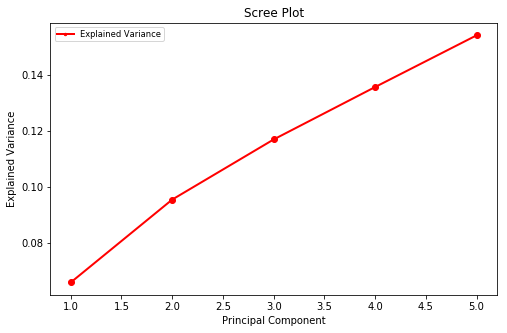

In [20]:

S = model.explainedVariance.toArray()
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(np.arange(num_vars) + 1, np.cumsum(S), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')


leg = plt.legend(['Explained Variance'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)

What do you think?  Is the cumulative explained variance enough to represent our data in fewer dimensions?


## Step 5: Re-Running the Correlation Matrix

In [21]:
## Checking the correlation matrix of the data.

r1 = Correlation.corr(pcaFeatures, "pcaFeatures").head()
print("Pearson correlation matrix:\n" + str(r1[0]))


Pearson correlation matrix:
DenseMatrix([[  1.00000000e+00,   2.19178051e-15,  -1.96118809e-15,
                1.19928863e-14,  -7.16527547e-16],
             [  2.19178051e-15,   1.00000000e+00,   4.94598957e-15,
               -1.55774434e-14,  -6.85746261e-15],
             [ -1.96118809e-15,   4.94598957e-15,   1.00000000e+00,
               -8.64329987e-15,  -2.69051328e-15],
             [  1.19928863e-14,  -1.55774434e-14,  -8.64329987e-15,
                1.00000000e+00,   7.28128485e-15],
             [ -7.16527547e-16,  -6.85746261e-15,  -2.69051328e-15,
                7.28128485e-15,   1.00000000e+00]])


Note the very small, close to zero correlations in the matrix.  The 5 dimensions are for all practical purposes independent and orthogonal.

### Step 6: Running PCA with more dimensions to get Explained Variance higher

Try to find at least 80% of explained variance.

Can we use the elbow method here?  Why (or why not)?

What does this say about the relative correlation of the dimensions?

Cumulative Explained Variance = 0.798923771179


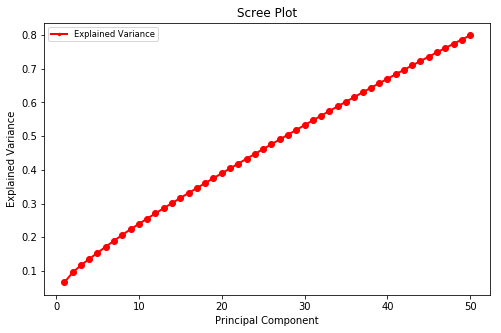

In [26]:
num_vars = 50 # Enter number of dimensions for explained Variance her.
pca = PCA(k=num_vars, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(ScaledFeatures)
pcaFeatures = model.transform(ScaledFeatures).select("pcaFeatures")


S = model.explainedVariance.toArray()
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(np.arange(num_vars) + 1, np.cumsum(S), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')


leg = plt.legend(['Explained Variance'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)

print("Cumulative Explained Variance = " + str(np.cumsum(S)[-1]))

### Conclusions

What are your conclusions?  Were we able to reduce dimensions in this dataset without losing much of the "signal" of the data?

Why or why not?